In [6]:
import re, string,os
from glob import glob as gb
import pandas as pd
from tqdm import tqdm
from collections import Counter
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
from functions import *
import calendar
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime
import matplotlib.dates as mdates
import nltk

from nltk.corpus import stopwords

base_path = "/home/ruben/Documents/GitHub/ParlaMintCase"

In [8]:
tf = pd.read_csv(base_path + '/resources/keywords-corona-translation.csv')
tf_corona = {language:dict(zip(tf[tf['language'] == language]['word'],tf[tf['language'] == language]['translation'])) for language in list(set(tf['language']))}

tf = pd.read_csv(base_path + '/resources/keywords-expertise-translation.csv')
tf_science = {language:dict(zip(tf[tf['language'] == language]['word'],tf[tf['language'] == language]['translation'])) for language in list(set(tf['language']))}
tf_science = {k:{x:i for x,i in v.items() if x not in ["policy","program","measures"]} for k,v in tf_science.items()}

In [47]:
def load(iso,language):
    df = data_loader.load_month(iso,'2020-01','2021-03')
    df = df = df[df['text'].notna()]
    stopwords_ = nltk.corpus.stopwords.words(language)
    df['text'] = [[w for w in str(t).split(' ') if "_" in w and len(w.split('_')) != 1] for t in df['posner']]
    df['text'] = [" ".join([w.split('_')[0] for w in text if w.split('_')[1] in ['NOUN']]) for text in df['text']]
    df['text'] = [utils.preprocess(str(x),stopwords_) for x in tqdm(df['text'])]
    df = df[df['text'].astype(str).str.contains("|".join(list(tf_science[iso].values())))].reset_index(drop=True)
    df = df[df['text'].astype(str).str.contains("|".join(list(tf_corona[iso].values())))].reset_index(drop=True)
    df = df.drop(['lemmatized','posner','title'],axis=1)
    print('length data',len(df))
    return df

In [48]:
df = load('nl','dutch')

100%|██████████| 61573/61573 [00:02<00:00, 23200.27it/s]
length data 613


In [60]:
# Top Terms

df = df.groupby(["from"]).agg({"text": lambda x: " ".join(x)}).reset_index()

r = pd.DataFrame()
tfidf_obj,docterms = tfidf.get_docterms(df,'text')
for day in sorted(list(set(df['from']))):
    df['dl'] = ["day" if date_ == day else "other" for date_ in df['from']]
    tftw = tfidf.get_topterms(tfidf_obj,docterms,df,'dl')
    r[day] = tftw['day'][:15]

In [61]:
dates = sorted(list(r.columns))
names = ["\n".join(list(r[d][:6])) for d in dates]
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]

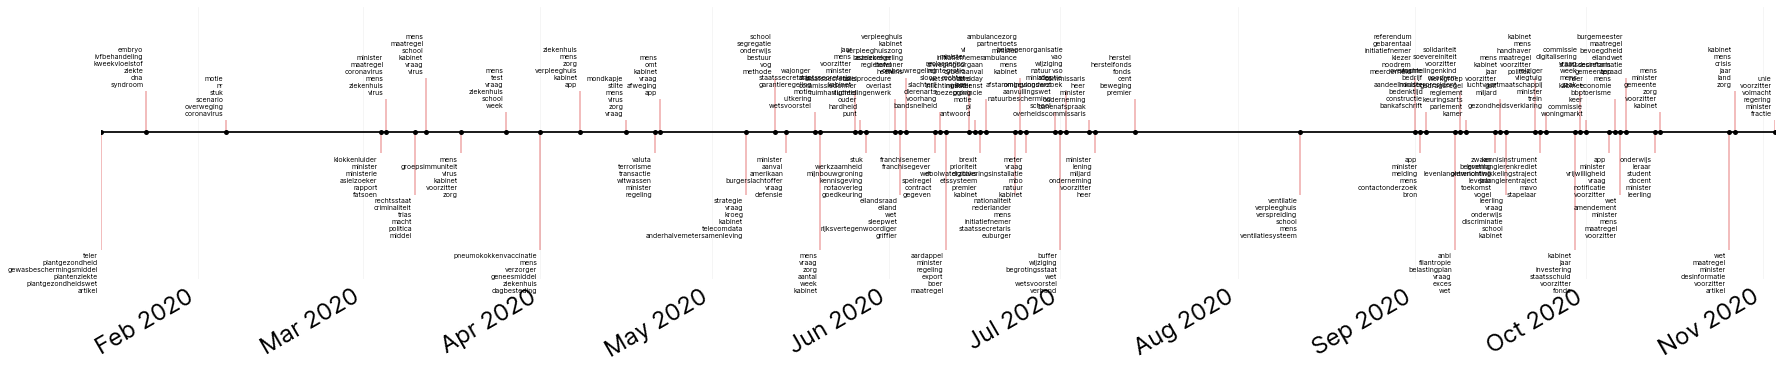

In [62]:
# Styling
plotting.style_()

levels = np.tile([-28, 10, 3, -5, 8, -15, 13, -5, 5],int(np.ceil(len(dates)/8)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(30, 5), constrained_layout=False)

ax.vlines(dates, 0, levels, color="tab:red",alpha=0.35)  # The vertical stems.
ax.plot(dates, np.zeros_like(dates), "-o",color="k", markerfacecolor="black",markersize=5)  # Baseline and markers on it.

# annotate lines
for d, l, r in zip(dates, levels, names):
    ax.annotate(r, xy=(d, l),
                xytext=(-3, np.sign(l)*3), textcoords="offset points",
                horizontalalignment="right",
                verticalalignment="bottom" if l > 0 else "top",
                fontsize=7)

# format xaxis with 4 month intervals
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right",fontsize=24)

# remove y axis and spines
ax.yaxis.set_visible(False)
# ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(y=0.1)
plt.ylim(-35,30)
plt.show()